In [2]:
import kagglehub
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import warnings

In [3]:
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

In [4]:

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
path = kagglehub.dataset_download("phylake1337/fire-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fire-dataset


In [6]:
path = path + '/fire_dataset'

In [7]:
print("Dataset structure:")
for root,dirs,files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' *2* (level + 1)
    for file in files[:5]:
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

Dataset structure:
fire_dataset/
  non_fire_images/
    non_fire.154.png
    non_fire.115.png
    non_fire.59.png
    non_fire.58.png
    non_fire.166.png
    ... and 239 more files
  fire_images/
    fire.743.png
    fire.717.png
    fire.157.png
    fire.26.png
    fire.314.png
    ... and 750 more files


In [8]:
fire_path = os.path.join(path, 'fire_images')
non_fire_path = os.path.join(path, 'non_fire_images')

fire_count = len([f for f in os.listdir(fire_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
non_fire_count = len([f for f in os.listdir(non_fire_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"\nDataset Statistics:")
print(f"Fire images: {fire_count}")
print(f"Non-fire images: {non_fire_count}")
print(f"Total images: {fire_count + non_fire_count}")


Dataset Statistics:
Fire images: 755
Non-fire images: 244
Total images: 999


In [18]:


IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2


train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT/2
)
test_datagen = ImageDataGenerator(
    rescale=1./255
    validation_split = VALIDATION_SPLIT/2)
print("Data generators created successfully!")


Data generators created successfully!


In [19]:


train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)


validation_generator = validation_datagen.flow_from_directory(
    path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)


test_gen = test_datagen.flow_from_directory(
    "images/test",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='test',
    shuffle=False
    seed=42
)

Found 800 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [20]:

# # Print class indices
# print("Class indices:", train_generator.class_indices)
# print(f"Training samples: {train_generator.samples}")
# print(f"Validation samples: {validation_generator.samples}")


In [21]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)


for layer in base_model.layers:
    layer.trainable = False

print(f"Base model loaded with {len(base_model.layers)} layers")
print("All convolutional layers frozen")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid', name='predictions')(x)


model = Model(inputs=base_model.input, outputs=predictions)

print("\nModel architecture:")
print(f"Total layers: {len(model.layers)}")
print(f"Trainable layers: {len([layer for layer in model.layers if layer.trainable])}")



Base model loaded with 19 layers
All convolutional layers frozen

Model architecture:
Total layers: 25
Trainable layers: 6


In [22]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,108,929 (57.64 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

print("Callbacks configured:")
print("- Early stopping with patience=10")
print("- Learning rate reduction with patience=5")



Callbacks configured:
- Early stopping with patience=10
- Learning rate reduction with patience=5


In [24]:

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

EPOCHS = 30

print("Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Steps per epoch: 25
Validation steps: 6
Starting training...
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7521 - loss: 0.5528 - val_accuracy: 0.8073 - val_loss: 0.4139 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8240 - loss: 0.3987 - val_accuracy: 0.8438 - val_loss: 0.3597 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8347 - loss: 0.3472 - val_accuracy: 0.8542 - val_loss: 0.3204 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8873 - loss: 0.2734 - val_accuracy: 0.8698 - val_loss: 0.3091 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8895 - loss: 0.2701 - val_accuracy: 0.8958 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9036 - loss: 0.2552 - val_accuracy: 0.8854 - val_loss: 0.2765 - learning_rate: 0.0010
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2

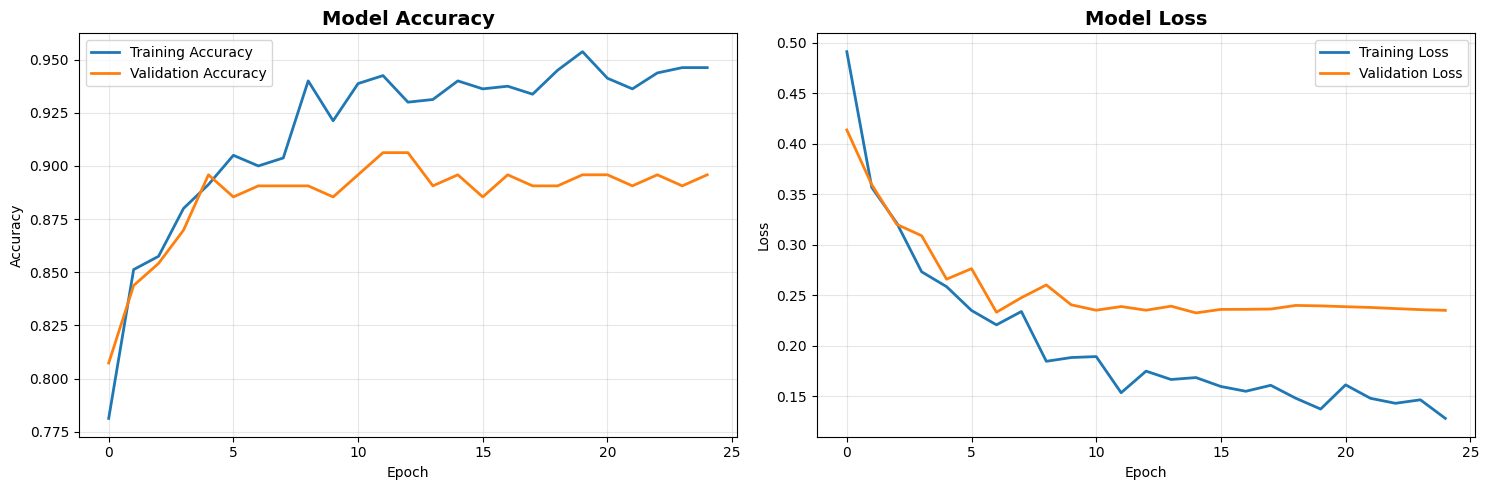


Final Training Accuracy: 0.9463
Final Validation Accuracy: 0.8958
Final Training Loss: 0.1283
Final Validation Loss: 0.2352


In [25]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")



In [36]:

print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_gen, verbose=0)
print(f"test Loss: {test_loss:.4f}")
print(f"test Accuracy: {test_accuracy:.4f}")

print("\nGenerating predictions for confusion matrix...")
test_gen.reset()
predictions = model.predict(test_gen, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

true_classes = test_gen.classes

class_names = list(test_gen.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))


Evaluating model on test set...
test Loss: 0.0983
test Accuracy: 93.2421

Generating predictions for confusion matrix...
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step

Classification Report:
                 precision    recall  f1-score   support

    fire_images       0.92      0.95      0.93       151
non_fire_images       0.82      0.75      0.78        48

       accuracy                           0.90       199
      macro avg       0.87      0.85      0.86       199
   weighted avg       0.90      0.90      0.90       199



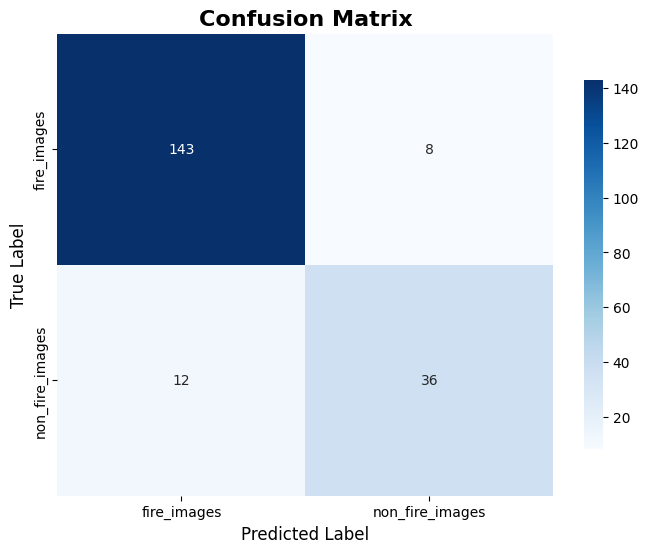


Detailed Metrics:
True Positives: 36
True Negatives: 143
False Positives: 8
False Negatives: 12
Precision: 0.8182
Recall: 0.7500
Specificity: 0.9470
F1-Score: 0.7826
Model saved as 'fire_classification_vgg16_model.h5'
Training history saved as 'training_history.pkl'


In [38]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={"shrink": .8})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp)

print(f"\nDetailed Metrics:")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# ===================================================================


model.save('fire_classification_vgg16_model.h5')
print("Model saved as 'fire_classification_vgg16_model.h5'")

import pickle
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("Training history saved as 'training_history.pkl'")

In [ ]:

def predict_single_image(model, img_path, class_names):
    """
    Predict the class of a single image
    """
    from tensorflow.keras.preprocessing import image

    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)[0][0]
    predicted_class = class_names[1] if prediction > 0.5 else class_names[0]
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return predicted_class, confidence




Prediction function defined. Use it to test individual images.
Project completed successfully!


In [ ]:
!ls {path}/fire_images

fire.100.png  fire.237.png  fire.373.png  fire.509.png	fire.645.png
fire.101.png  fire.238.png  fire.374.png  fire.50.png	fire.646.png
fire.102.png  fire.239.png  fire.375.png  fire.510.png	fire.647.png
fire.103.png  fire.23.png   fire.376.png  fire.511.png	fire.648.png
fire.104.png  fire.240.png  fire.377.png  fire.512.png	fire.649.png
fire.105.png  fire.241.png  fire.378.png  fire.513.png	fire.64.png
fire.106.png  fire.242.png  fire.379.png  fire.514.png	fire.650.png
fire.107.png  fire.243.png  fire.37.png   fire.515.png	fire.651.png
fire.108.png  fire.244.png  fire.380.png  fire.516.png	fire.652.png
fire.109.png  fire.245.png  fire.381.png  fire.517.png	fire.653.png
fire.10.png   fire.246.png  fire.382.png  fire.518.png	fire.654.png
fire.110.png  fire.247.png  fire.383.png  fire.519.png	fire.655.png
fire.111.png  fire.248.png  fire.384.png  fire.51.png	fire.656.png
fire.112.png  fire.249.png  fire.385.png  fire.520.png	fire.657.png
fire.113.png  fire.24.png   fire.386.png  fire.521.

In [ ]:
sample_img_path = f"{path}/fire_images/fire.506.png"

In [ ]:
sample_img_path

'/root/.cache/kagglehub/datasets/phylake1337/fire-dataset/versions/1/fire_dataset/fire_images/fire.506.png'

In [ ]:
img_path = sample_img_path
predicted_class, confidence = predict_single_image(model, img_path, class_names)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: fire_images
Confidence: 0.9927
